## Process data from NCAR Mesa Lab for ATOC4500 Data Science - 2017
written by: Jennifer.E.Kay@colorado.edu
last updated: Feb. 19, 2022

Original daily netcdf data for 2017 in .cdf format from ftp://ftp.eol.ucar.edu/pub/archive/weather  
All files are here but still failing NEED TO LOOK

Procssed here to:
1) make data continuous, add missing value when no data present (-999)
2) put all data into a single file

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np   # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
import datetime
import scipy.stats as stats
import glob
from datetime import date

In [2]:
### set up and testing
print(date.today())

## read in an example file -- check on the contents
filedir='mesa/'
filename='mlab.20170101.cdf'
ds_example=xr.open_dataset(filedir+filename)
print(ds_example)

print(ds_example['wspd'].shape)
print(ds_example['base_time'].values)
print(ds_example['time_offset'].values)
print(ds_example['time_offset'].shape)
#plt.plot(ds_example['wspd']);

2022-02-19
<xarray.Dataset>
Dimensions:      (time: 286)
Dimensions without coordinates: time
Data variables: (12/20)
    base_time    int32 ...
    samp_secs    int32 ...
    lat          float32 ...
    lon          float32 ...
    alt          float32 ...
    station      int32 ...
    ...           ...
    wmax         (time) float32 ...
    wsdev        (time) float32 ...
    wchill       (time) float32 ...
    raina        (time) float32 ...
    raina24      (time) float32 ...
    bat          (time) float32 ...
(286,)
1483228800
[    0.   300.   600.   900.  1200.  1500.  1800.  2100.  2400.  2700.
  3000.  3300.  3600.  3900.  4200.  4500.  4800.  5100.  5400.  5700.
  6000.  6300.  6600.  6900.  7200.  7500.  7800.  8100.  8400.  8700.
  9000.  9300.  9600.  9900. 10200. 10500. 10800. 11100. 11400. 11700.
 12000. 12300. 12600. 12900. 13200. 13500. 13800. 14100. 14400. 14700.
 15000. 15300. 15600. 15900. 16200. 16500. 16800. 17100. 17400. 17700.
 18000. 18300. 18900. 19200. 195

In [3]:
### here I read in all of the nc files for 2017

filedir='mesa/'

files=sorted(glob.glob(filedir+'mlab.2017*.cdf'))

#print(files)
print(type(files))
print(f'number of files: {len(files)}')
if len(files)<365:
    print('there is NOT A FULL CALENDAR YEAR HERE...')
    print('MORE CODING IS NEEDED')

<class 'list'>
number of files: 365


In [4]:
### loop to check the dimensions of the files, determine when and how many have missing vales
count=0
for i in np.arange(0,len(files)):
    foo=xr.open_dataset(files[i])
    if (len(foo['wspd'])!=288):
        print(files[i])
        #print(len(foo['wspd_max']))
        count=count+1        
print(f'# of days with missing values: {count}') 

mesa/mlab.20170101.cdf
mesa/mlab.20170102.cdf
mesa/mlab.20170104.cdf
mesa/mlab.20170105.cdf
mesa/mlab.20170106.cdf
mesa/mlab.20170107.cdf
mesa/mlab.20170111.cdf
mesa/mlab.20170114.cdf
mesa/mlab.20170119.cdf
mesa/mlab.20170124.cdf
mesa/mlab.20170127.cdf
mesa/mlab.20170206.cdf
mesa/mlab.20170216.cdf
mesa/mlab.20170217.cdf
mesa/mlab.20170218.cdf
mesa/mlab.20170219.cdf
mesa/mlab.20170224.cdf
mesa/mlab.20170225.cdf
mesa/mlab.20170228.cdf
mesa/mlab.20170301.cdf
mesa/mlab.20170306.cdf
mesa/mlab.20170322.cdf
mesa/mlab.20170324.cdf
mesa/mlab.20170325.cdf
mesa/mlab.20170329.cdf
mesa/mlab.20170404.cdf
mesa/mlab.20170405.cdf
mesa/mlab.20170406.cdf
mesa/mlab.20170408.cdf
mesa/mlab.20170415.cdf
mesa/mlab.20170417.cdf
mesa/mlab.20170424.cdf
mesa/mlab.20170429.cdf
mesa/mlab.20170502.cdf
mesa/mlab.20170506.cdf
mesa/mlab.20170507.cdf
mesa/mlab.20170512.cdf
mesa/mlab.20170513.cdf
mesa/mlab.20170514.cdf
mesa/mlab.20170517.cdf
mesa/mlab.20170518.cdf
mesa/mlab.20170519.cdf
mesa/mlab.20170610.cdf
mesa/mlab.2

In [5]:
for i in np.arange(0,len(files)):
    foo=xr.open_dataset(files[i])
    pres=foo['pres'].values
    if (len(foo['pres'])>288):
        print(len(foo['pres']))
        print(files[i])

289
mesa/mlab.20170724.cdf
289
mesa/mlab.20171128.cdf


In [6]:
### loop over all days  when there is a missing data file - deal with it!
### fill in all missing values as -999
pres_all=[]
tdry_all=[]
rh_all=[]
wdir_all=[]
wspd_all=[]
wspdmax_all=[]
raina_all=[]

count=0
for i in np.arange(0,len(files)):
    print(f'working on {files[i]}')
    foo=xr.open_dataset(files[i])
    pres=foo['pres'].values
    tdry=foo['tdry'].values
    rh=foo['rh'].values
    wdir=foo['wdir'].values
    wspd=foo['wspd'].values
    wspdmax=foo['wmax'].values  
    raina=foo['raina'].values
    
    if (len(foo['pres'])==288):
        pres_all=np.append(pres_all,pres)
        tdry_all=np.append(tdry_all,tdry)
        rh_all=np.append(rh_all,rh)
        wdir_all=np.append(wdir_all,wdir)
        wspd_all=np.append(wspd_all,wspd)
        wspdmax_all=np.append(wspdmax_all,wspdmax)
        raina_all=np.append(raina_all,raina)
        #print(pres_all.shape)
        #break
    
    if (len(pres)!=288):
        print(f'need to add missing values or fix repetitive values in {files[i]}')
        #print(len(foo['pres']))
        count=count+1
        match_idx=[]
        ## read in seconds since midnight - variable is 'time_offset' in .cdf files
        timefoo=foo['time_offset']
        some_seconds_notuniq=timefoo.values.astype(int)
        ## find uniq_idx - i.e., index of unique times where there are non-missing values
        foo,uniq_idx=np.unique(some_seconds_notuniq,return_index=True)
        #print(f'length of uniq_idx {len(uniq_idx)}')
        ## find unique values of some_seconds - i.e., unique times where there are non-missing values
        some_seconds=np.unique(timefoo.values.astype(int))
        #print(type(some_seconds))
        #print(f'length of some_seconds {some_seconds.shape}')
        #print(f'length of some_seconds_notuniq {some_seconds_notuniq.shape}')
        ## initialize all_seconds - full array of seconds
        all_seconds=np.arange(0,86400,300)
        #print(f'length of all_seconds {all_seconds.shape}')
        ### THEN - find where the time arrays match -- length of some_seconds
        match_idx=np.arange(all_seconds.shape[0])[np.in1d(all_seconds,some_seconds)]
        #print(f'length of match_idx {match_idx.shape}')          
        ## initialize arrays with same dimensions as all_seconds with value of fill value (-999)
        some_seconds_withmissing=np.zeros(len(all_seconds))-999
        pres_withmissing=np.zeros(len(all_seconds))-999
        tdry_withmissing=np.zeros(len(all_seconds))-999
        rh_withmissing=np.zeros(len(all_seconds))-999       
        wdir_withmissing=np.zeros(len(all_seconds))-999  
        wspd_withmissing=np.zeros(len(all_seconds))-999  
        wspdmax_withmissing=np.zeros(len(all_seconds))-999
        raina_withmissing=np.zeros(len(all_seconds))-999        
        ## next fill in the some_seconds_withmissing arrays where there is a good value (i.e., at match_idx)
        some_seconds_withmissing[match_idx]=all_seconds[match_idx]
        ## repeat with the variables - starting with pres
        #print(pres[uniq_idx].shape)    ## only the unique non-fill values, size < 288
        #print(pres_withmissing.shape)  ##with the fill values, size=288
        pres_withmissing[match_idx]=pres[uniq_idx]
        #print(pres_withmissing)  ## check that the missing values are appearing
        #break
        tdry_withmissing[match_idx]=tdry[uniq_idx]
        rh_withmissing[match_idx]=rh[uniq_idx] 
        wdir_withmissing[match_idx]=wdir[uniq_idx]
        wspd_withmissing[match_idx]=wspd[uniq_idx]
        wspdmax_withmissing[match_idx]=wspdmax[uniq_idx]
        raina_withmissing[match_idx]=raina[uniq_idx]
        ## append array with missing values
        pres_all=np.append(pres_all,pres_withmissing)
        tdry_all=np.append(tdry_all,tdry_withmissing)
        rh_all=np.append(rh_all,rh_withmissing)
        wdir_all=np.append(wdir_all,wdir_withmissing)
        wspd_all=np.append(wspd_all,wspd_withmissing)
        wspdmax_all=np.append(wspdmax_all,wspdmax_withmissing)
        raina_all=np.append(raina_all,raina_withmissing)
        ### sanity check
        sanity="no"
        if sanity=="yes":## and files2021[i]=='mesa/mlab.20210522.nc':
            print("sanity check - will break afterwards")
            print(tdry_withmissing)
            print(tdry_withmissing.shape)
            #print(tdry[-289:])
            #print(tdry[-289:].shape)
            plt.plot(tdry[-289:],'.')
            plt.show()
            break


working on mesa/mlab.20170101.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170101.cdf
working on mesa/mlab.20170102.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170102.cdf
working on mesa/mlab.20170103.cdf
working on mesa/mlab.20170104.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170104.cdf
working on mesa/mlab.20170105.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170105.cdf
working on mesa/mlab.20170106.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170106.cdf
working on mesa/mlab.20170107.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170107.cdf
working on mesa/mlab.20170108.cdf
working on mesa/mlab.20170109.cdf
working on mesa/mlab.20170110.cdf
working on mesa/mlab.20170111.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170111.cdf
working on mesa/mlab.20170112.cdf
working on mesa/mlab.20170113.cdf
working on m

working on mesa/mlab.20170602.cdf
working on mesa/mlab.20170603.cdf
working on mesa/mlab.20170604.cdf
working on mesa/mlab.20170605.cdf
working on mesa/mlab.20170606.cdf
working on mesa/mlab.20170607.cdf
working on mesa/mlab.20170608.cdf
working on mesa/mlab.20170609.cdf
working on mesa/mlab.20170610.cdf
need to add missing values or fix repetitive values in mesa/mlab.20170610.cdf
working on mesa/mlab.20170611.cdf
working on mesa/mlab.20170612.cdf
working on mesa/mlab.20170613.cdf
working on mesa/mlab.20170614.cdf
working on mesa/mlab.20170615.cdf
working on mesa/mlab.20170616.cdf
working on mesa/mlab.20170617.cdf
working on mesa/mlab.20170618.cdf
working on mesa/mlab.20170619.cdf
working on mesa/mlab.20170620.cdf
working on mesa/mlab.20170621.cdf
working on mesa/mlab.20170622.cdf
working on mesa/mlab.20170623.cdf
working on mesa/mlab.20170624.cdf
working on mesa/mlab.20170625.cdf
working on mesa/mlab.20170626.cdf
working on mesa/mlab.20170627.cdf
working on mesa/mlab.20170628.cdf
work

working on mesa/mlab.20171221.cdf
working on mesa/mlab.20171222.cdf
working on mesa/mlab.20171223.cdf
working on mesa/mlab.20171224.cdf
working on mesa/mlab.20171225.cdf
working on mesa/mlab.20171226.cdf
working on mesa/mlab.20171227.cdf
working on mesa/mlab.20171228.cdf
working on mesa/mlab.20171229.cdf
working on mesa/mlab.20171230.cdf
working on mesa/mlab.20171231.cdf


In [7]:
print(f'Reminder Number of days with missing info: {count}') 
print('shape of all variables - should be ndays*288 (105120 for a full year)')
print(pres_all.shape)
print(tdry_all.shape)
print(wdir_all.shape)
print(wspd_all.shape)
print(wspdmax_all.shape)
print(raina_all.shape) 

Reminder Number of days with missing info: 68
shape of all variables - should be ndays*288 (105120 for a full year)
(105120,)
(105120,)
(105120,)
(105120,)
(105120,)
(105120,)


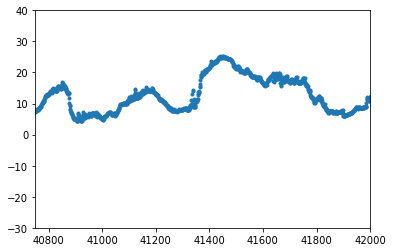

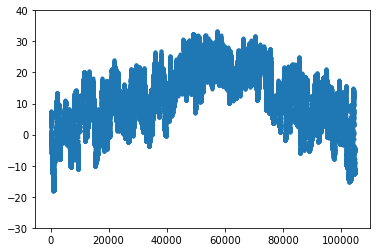

In [8]:
#### sanity plot the data to check it
plt.plot(tdry_all,'.')
plt.ylim(-30,40)
plt.xlim(40750,42000) ## this is a time period with missing data
plt.show()

plt.plot(tdry_all[289:],'.') ## this plots the last day (last 289 values)
plt.ylim(-30,40) 
plt.show()
#print(tdry_all[289:])  

105120


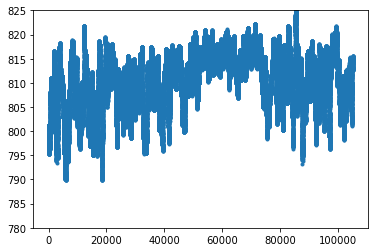

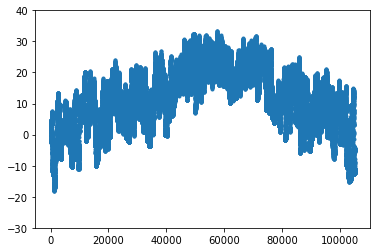

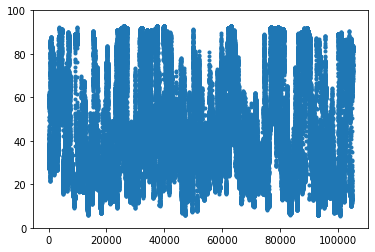

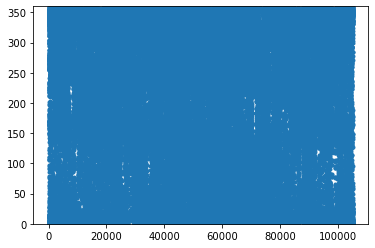

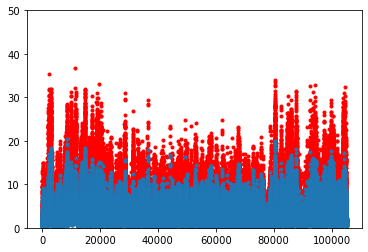

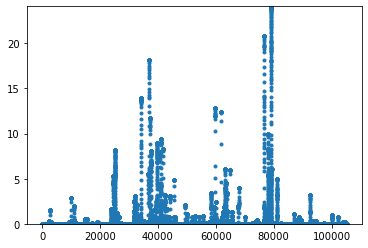

In [9]:
#### more sanity plots the data to check it - plot the entire timeseries for all variables

plt.plot(pres_all,'.')
plt.ylim(780,825)
print(len(pres_all))
plt.show()

plt.plot(tdry_all,'.')
plt.ylim(-30,40)
plt.show()

plt.plot(rh_all,'.')
plt.ylim(0,100)
plt.show()

plt.plot(wdir_all,'.')
plt.ylim(0,360)
plt.show()

plt.plot(wspdmax_all,'.',color='r')
plt.plot(wspd_all,'.')
plt.ylim(0,50)
plt.show()

plt.plot(raina_all,'.')
plt.ylim(0,max(raina_all))
plt.show()

In [10]:
## create time arrays that are useful 
## hours (fractional hours within a day) and day (julian day)

## create all the seconds in a day
n_seconds_day=24*60*60
n_seconds_5minute=5*60 ## number of seconds in the timestep
#all_seconds=np.arange(0,n_seconds_day+n_seconds_5minute,n_seconds_5minute)
all_seconds=np.arange(0,n_seconds_day,n_seconds_5minute)
print(all_seconds.shape)
print(all_seconds)

# create all the seconds in all of the days
day=np.ones(288)*0
seconds=all_seconds
for i in np.arange(1,len(files)):
    foo=np.ones(288)*i
    #print(foo)
    day=np.append(day,foo)
    #print(day)
    seconds=np.append(seconds,all_seconds)
    #print(seconds)

## convert to fractional hours
hours=seconds/(60*60.)

## convert to julian day
day=day+1

## check the shapes
print(day.shape)
print(hours.shape)

## check the first ten values
print(day[0:10])
print(hours[0:10])

## check the last ten values
print(day[-10:])
print(hours[-10:])

(288,)
[    0   300   600   900  1200  1500  1800  2100  2400  2700  3000  3300
  3600  3900  4200  4500  4800  5100  5400  5700  6000  6300  6600  6900
  7200  7500  7800  8100  8400  8700  9000  9300  9600  9900 10200 10500
 10800 11100 11400 11700 12000 12300 12600 12900 13200 13500 13800 14100
 14400 14700 15000 15300 15600 15900 16200 16500 16800 17100 17400 17700
 18000 18300 18600 18900 19200 19500 19800 20100 20400 20700 21000 21300
 21600 21900 22200 22500 22800 23100 23400 23700 24000 24300 24600 24900
 25200 25500 25800 26100 26400 26700 27000 27300 27600 27900 28200 28500
 28800 29100 29400 29700 30000 30300 30600 30900 31200 31500 31800 32100
 32400 32700 33000 33300 33600 33900 34200 34500 34800 35100 35400 35700
 36000 36300 36600 36900 37200 37500 37800 38100 38400 38700 39000 39300
 39600 39900 40200 40500 40800 41100 41400 41700 42000 42300 42600 42900
 43200 43500 43800 44100 44400 44700 45000 45300 45600 45900 46200 46500
 46800 47100 47400 47700 48000 48300 48600 4

In [11]:
## check the shapes - should all be the same
print(day.shape)
print(hours.shape)
print(pres_all.shape)
print(tdry_all.shape)
print(wdir_all.shape)
print(wspd_all.shape)
print(wspdmax_all.shape)

## check the first ten values
print(day[0:10])
print(hours[0:10])
print(pres_all[0:10])
print(tdry_all[0:10])
print(wdir_all[0:10])
print(wspd_all[0:10])
print(wspdmax_all[0:10])

## check the last ten values
print(day[-10:])
print(hours[-10:])
print(pres_all[-10:])
print(tdry_all[-10:])
print(wdir_all[-10:])
print(wspd_all[-10:])
print(wspdmax_all[-10:])

(105120,)
(105120,)
(105120,)
(105120,)
(105120,)
(105120,)
(105120,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75      ]
[800.5        800.5        800.5        800.5        800.70001221
 800.70001221 800.79998779 800.79998779 800.79998779 800.90002441]
[-0.30000001 -0.40000001 -0.5        -0.40000001 -0.2        -0.40000001
 -0.5        -0.60000002 -0.89999998 -1.10000002]
[333. 275. 231. 173.  55.   1.   8.   4.  17.   5.]
[0.40000001 0.60000002 0.69999999 0.80000001 1.5        1.5
 1.70000005 1.89999998 2.0999999  2.20000005]
[1.20000005 1.5        1.70000005 2.0999999  2.79999995 2.
 2.0999999  2.4000001  2.79999995 2.79999995]
[365. 365. 365. 365. 365. 365. 365. 365. 365. 365.]
[23.16666667 23.25       23.33333333 23.41666667 23.5        23.58333333
 23.66666667 23.75       23.83333333 23.91666667]
[815.29998779 815.40002441 815.40002441 815.40002441 815.20001221
 815.40002441 815.4000244

In [12]:
#### Save it out as a netcdf file

## 1d data (day)
data_vars={'days': (['day'],       day,{'units': 'days_foolingxarray'}),\
          'hour_frac': (['day'],  hours,{'units': 'hours_in_day_since_00_UTC'}),\
          'pres': (['day'],       pres_all,{'units': 'millibars'},{'_FillValue': '-999'}),\
          'tdry': (['day'],       tdry_all,{'units': 'deg_C'},{'_FillValue': '-999'}),\
          'rh': (['day'],         rh_all,{'units': 'percent'},{'_FillValue': '-999'}),\
          'wdir': (['day'],       wdir_all,{'units': 'degrees'},{'_FillValue': '-999'}),\
          'wspd': (['day'],       wspd_all,{'units': 'meters_per_second'},{'_FillValue': '-999'}),\
          'wspdmax': (['day'],    wspdmax_all,{'units': 'meters_per_second'},{'_FillValue': '-999'}),\
          'raina_event': (['day'], raina_all,{'units': 'millimeters'},{'_FillValue': '-999'}),\
          }
ds = xr.Dataset(data_vars,coords={'day':(['day'],day)})
ds.attrs['site']='Mesa Lab NCAR 5-minute (360 second) weather data'
ds.attrs['data_from']='ftp://ftp.eol.ucar.edu/pub/archive/weather'
ds.attrs['processed_date']=np.str(date.today())
ds.attrs['contact']='Jennifer.E.Kay@colorado.edu'
fname='mesalab_2017_data.nc'
ds.to_netcdf(fname)

/var/folders/lf/2cw588z11_9dgwq8fdplpcp80000gp/T/ipykernel_1278/1182927489.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ds.attrs['processed_date']=np.str(date.today())


In [13]:
print(wspdmax_all[-1:])
print(wspd_all[-1:])
print(wspdmax_all[1])
print(wspd_all[1])

[1.79999995]
[0.69999999]
1.5
0.6000000238418579


In [14]:
ds=xr.open_dataset('mesalab_2017_data.nc',decode_times=False)
df = ds.to_dataframe()

## preview data (also through df.head() & df.tail())
df

,days,hour_frac,pres,tdry,rh,wdir,wspd,wspdmax,raina_event
day,,,,,,,,,
1.0,1.0,0.000000,800.500000,-0.3,55.099998,333.0,0.4,1.2,0.0
1.0,1.0,0.083333,800.500000,-0.4,55.500000,275.0,0.6,1.5,0.0
1.0,1.0,0.166667,800.500000,-0.5,56.200001,231.0,0.7,1.7,0.0
1.0,1.0,0.250000,800.500000,-0.4,55.900002,173.0,0.8,2.1,0.0
1.0,1.0,0.333333,800.700012,-0.2,55.000000,55.0,1.5,2.8,0.0
...,...,...,...,...,...,...,...,...,...
365.0,365.0,23.583333,815.400024,-11.5,82.800003,344.0,0.8,1.4,0.0
365.0,365.0,23.666667,815.400024,-11.5,82.800003,21.0,0.5,1.3,0.0
365.0,365.0,23.750000,815.400024,-11.6,83.099998,96.0,0.7,1.5,0.0


In [15]:
df.days.nunique()

365

In [16]:
#### Save data frame to csv file

df.to_csv('mesalab_2017_data.csv', index=False)